In [32]:
#loading dependencies
import numpy as np
import math
from pprint import pprint
import random
import operator
%matplotlib inline
import matplotlib as mpl

import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import matplotlib #only needed to determine Matplotlib version number

from os import listdir
from os.path import isfile, join
import csv

#import folium
from IPython.display import HTML,IFrame

import datetime

In [33]:
def to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H:%M:%S')

def load_data(path):   
    # ==> Loading Merged Station Data
    data = pd.read_json(path)
    # ==> Converting timestamp to pandas timestamp datatype
    data['last_update'] = data['last_update'].map(to_datetime)
    data['last_update'] = pd.to_datetime(data['last_update'])
    # ==> Rebuilding Multiindex
    data.set_index(["number",'last_update'],inplace=True,drop=True)
    # ==> Sort index by number & timestamp
    data.sort_index(inplace=True)
    return data

In [34]:
data = load_data('challenge_data/stations_merged.json')

In [36]:
data.head()

address  \
number last_update                                         
1010   2015-09-01 01:51:43  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:01:47  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:11:50  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:21:53  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:31:57  10 RUE BOUCHER - 75001 PARIS   

                            available_bike_stands  available_bikes banking  \
number last_update                                                           
1010   2015-09-01 01:51:43                     25                0    True   
       2015-09-01 02:01:47                     25                0    True   
       2015-09-01 02:11:50                     25                0    True   
       2015-09-01 02:21:53                     25                0    True   
       2015-09-01 02:31:57                     25                0    True   

                            bike_stands  bonus contract_name  index  \
number last_update                                                    
1010   2015-09-01 01:51:43           25  False         Paris  14015   
       2015-09-01 02:01:47           25  False         Paris   7503   
       2015-09-01 02:11:50           25  False         Paris  12609   
       2015-09-01 02:21:53           25  False         Paris    557   
       2015-09-01 02:31:57           25  False         Paris  10262   

                                  lat       lng               name status  
number last_update                                                         
1010   2015-09-01 01:51:43  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:01:47  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:11:50  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:21:53  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:31:57  48.859462  2.344366  01010 - PONT NEUF   OPEN

##### Null Data ?
The dataset does not include any N/A datapoint

In [6]:
data.isnull().sum()

address                  0
available_bike_stands    0
available_bikes          0
banking                  0
bike_stands              0
bonus                    0
contract_name            0
index                    0
lat                      0
lng                      0
name                     0
status                   0
dtype: int64

## 1. Static Data

- ```number``` le numéro de la station. Attention, ce n'est pas un id, ce numéro n'est unique qu'au sein d'un contrat
- ```contract_name``` le nom du contrat de cette station
- ```name``` le nom de la station
- ```address``` adresse indicative de la station, les données étant brutes, parfois il s'agit plus d'un commentaire que d'une adresse.
- ```position``` les coordonnées au format WGS84
- ```banking``` indique la présence d'un terminal de paiement
- ```bonus``` indique s'il s'agit d'une station bonus
- ```bike_stands``` is also considered static on the data set

### Building the station table

In [7]:
stations = data.groupby(level = "number").first()
stations = stations[["bike_stands","name","address","lat","lng",'banking','bonus']]
stations.head()

,bike_stands,name,address,lat,lng,banking,bonus
number,,,,,,,
1010,25,01010 - PONT NEUF,10 RUE BOUCHER - 75001 PARIS,48.859462,2.344366,True,False
1012,22,01012 - BOURSE DU COMMERCE,FACE 29 RUE JEAN JACQUES ROUSSEAU - 75001 PARIS,48.862998,2.341555,True,False
1013,66,01013 - SAINT HONORE,186 RUE SAINT HONORE - 75001 PARIS,48.862430,2.338520,True,False
1014,25,01014 - RIVOLI MUSEE DU LOUVRE,5 RUE DE L'ECHELLE - 75001 PARIS,48.863672,2.334058,True,False
1015,20,01015 - PLACE ANDRE MALRAUX,2 PLACE ANDRE MALRAUX - 75001 PARIS,48.863980,2.335600,True,False


### 1.a) Number, contract_name, name and address
N/A


### 1.b) Bike Stands
=> Very diverse number of stands depending on station type
=> Predicting the number of available bikes might be dangerous

In [8]:
bike_stands = data.groupby(level=['number']).agg({'bike_stands':[np.min,np.max]})
bike_stands.columns = bike_stands.columns.droplevel()
bike_stands["is_static"] = bike_stands["amin"] == bike_stands["amax"]
bike_stands["is_static"].value_counts()
# => bike_stands do not evolve across time, considered a static variable

True    45
Name: is_static, dtype: int64

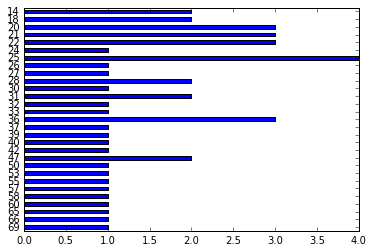

In [9]:
stations["bike_stands"].value_counts().sort_index(ascending=False).plot(kind='barh')

In [10]:
def build_folium_map(stations,radius_metric,popup_col,map_path,radius_factor=2):
    # ==> Center position for the Map
    location_center = data[["lat",'lng']].mean().tolist()
    print location_center
    # ==> Building the Map
    paris_map = folium.Map(location=location_center,zoom_start=13, tiles='Stamen Toner')
    # ==> Adding Stations
    for (i,el) in stations.iterrows():
        folium.CircleMarker([el["lat"], el["lng"]],radius=el[radius_metric]*radius_factor,popup= el[popup_col],color='#3186cc',fill_color='#3186cc').add_to(paris_map) 
    # ==> Saving to html file
    paris_map.create_map(path=map_path)
    
# ==> Displaying html file in Iframe
build_folium_map(stations,'bike_stands','name','graphs/bike_stands_stations.html')
IFrame('graphs/bike_stands_stations.html', width=700, height=350)

[48.858663181591702, 2.331525463802405]


NameError: global name 'folium' is not defined

### 1.c) Location
Only three districs, the 1st, 4th and 7th

In [11]:
import re

def get_district(address):
    m = re.search('.*(\d{5}).*', address)
    if m:
        found = m.group(1)
        return found[-2:]
    
stations["district"] = stations["address"].map(get_district)

In [12]:
stations["district"].value_counts()

07    17
01    16
04    12
Name: district, dtype: int64

### 1.d) Bonus Stations
All stations are not bonus => could have been a good proxy for elevation

In [13]:
stations["bonus"].value_counts()

False    45
Name: bonus, dtype: int64

### 1.d) Banking Stations
All station have a payment facility => not discriminatory

In [14]:
stations["banking"].value_counts()

True    45
Name: banking, dtype: int64

##  Key learnings - 1. Static Data

- ```banking``` and  ```bonus``` columns can be removed since they do not provide any info
- stations provided have a very diverse ```bike_stands```
- only three districts are covered, the 1st,

In [15]:
del data["banking"]
del data["bonus"]

## 2. Dynamic Data
- ```status``` indique l'état de la station, peut être CLOSED ou OPEN
- ```bike_stands``` le nombre de points d'attache opérationnels
- ```available_bike_stands``` le nombre de points d'attache disponibles pour y ranger un vélo
- ```available_bikes``` le nombre de vélos disponibles et opérationnels
- ```last_update``` timestamp indiquant le moment de la dernière mise à jour en millisecondes depuis Epoch

### 2.a)  ```last_update``` : Understanding time indexing in data

In [16]:
#### Looking at the time range
date_range  = data.reset_index(level ='last_update').groupby(level='number').agg({'last_update':[np.min,np.max],'name':len})
date_range.head()

name         last_update                    
          len                amin                amax
number                                               
1010    15850 2015-09-01 01:51:43 2015-12-01 00:46:38
1012    16230 2015-09-01 01:52:59 2015-12-01 00:46:28
1013    18618 2015-09-01 01:49:03 2015-12-01 00:51:08
1014    15583 2015-09-01 01:51:24 2015-11-30 22:25:03
1015    17592 2015-09-01 01:51:12 2015-12-01 00:46:22

In [17]:
#### Start datetime
print 'Min Start Date %s' % date_range[("last_update",'amin')].min()
print 'Max Start Date %s' % date_range[("last_update",'amin')].max()

Min Start Date 2015-09-01 01:49:03
Max Start Date 2015-09-01 01:59:04


In [18]:
#### End datetime
print 'Min End Date %s' % date_range[("last_update",'amax')].min()
print 'Max End Date %s' % date_range[("last_update",'amax')].max()

Min End Date 2015-11-30 22:25:03
Max End Date 2015-12-01 00:54:43


Min range of days 90.8567013889
Max range of days 90.9618171296


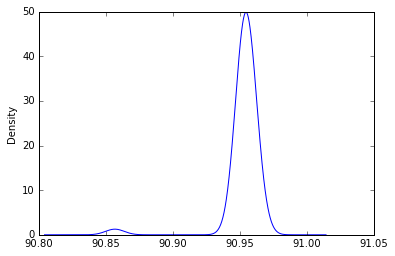

In [19]:
#### Number of Days
date_range["day_range"] = (date_range[('last_update','amax')] - date_range[('last_update','amin')])
date_range["day_range"] = date_range["day_range"].dt.total_seconds()/(3600*24)
date_range["day_range"].plot(kind='density')
print 'Min range of days %s' % date_range["day_range"].min()
print 'Max range of days %s' % date_range["day_range"].max()

=> Range covered accross stations is stable

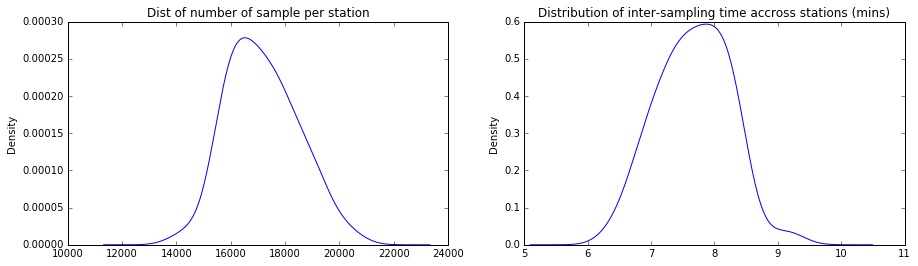

In [20]:
##### Number of Data Points
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
date_range[('name','len')].plot(kind='density',title='Dist of number of sample per station', ax=axes[0])
date_range["mean_freq"] =  date_range['day_range']/ date_range[("name","len")]*(24*60)
date_range["mean_freq"].plot(kind='density',title='Distribution of inter-sampling time accross stations (mins)',ax=axes[1])
plt.show()

=> Time series are irregular

### 2.b) ```available_bikes``` per station accross time
=> Here the idea is to assess if there are different cluster of stations based on time series patterns

In [21]:
data = data.reset_index()

In [22]:
data['tot_bikes']= data['available_bikes'] + data['available_bike_stands'] 

In [23]:
def timeseries_table(data,value_key):
    table = data.pivot_table(index='last_update', columns='name', values=value_key,aggfunc= np.min)
    return table

av_bikes_table = timeseries_table(data,'available_bikes')
tot_bikes_table = timeseries_table(data,'tot_bikes')

#### Finding the right sampling

In [24]:
def sample_timeseries(data,data_n,stations,sample_time):
    # ==> resampling data on a 30 min range
    data_s = data.resample(str(sample_time) + 'min').mean()
    data_n_s = data_n.resample(str(sample_time) + 'min').max()
    # ==> normalizing bike availability accross stations
    table = data_s.div(data_n_s)*100
        
    return table

In [25]:
## => sampling 
av_bikes_sampled = sample_timeseries(av_bikes_table,tot_bikes_table,stations,10)

In [26]:
sampled_data.ix[start_date:end_date,selected_colums]

NameError: name 'sampled_data' is not defined

In [ ]:
def multi_station_plot(sampled_data,station_name,start_date,end_datel,legend=False):
    # ==> ploting time serie on a given time frame
    sampled_data.ix[start_date:end_date,selected_colums].plot(figsize=(20,8),legend=legend)
    
# ==> choosing station to plot
selected_colums = av_bikes_sampled.columns.values[0:10]
start_date  = datetime.datetime(2015,11,13,0,0,0)
end_date  =  datetime.datetime(2015,11,15,0,0,0)
multi_station_plot(av_bikes_sampled,selected_colums,start_date,end_date)

#### Averaging on week

In [27]:
def average_on_week(sampled_data):
    
    def map_date_strings(x):
        month_map = {0:"Mon",1:'Tues',2:"Wed",3:'Thurs',4:"Fri",5:'Sat',6:"Sun"}
        return month_map[x[0]] + '  ' + str(x[1]) +':' + str(x[2])
    
    time_index = sampled_data.index
    aow = sampled_data.groupby([time_index.dayofweek,time_index.hour,time_index.minute]).mean()
    aow.index = aow.index.map(map_date_strings)
    return aow

In [28]:
def average_per_district(aow,stations,district):
    # ==> choosing station to plot
    selected_colums = stations[stations.district == district]['name']
    # ==> ploting time serie on a given time frame
    aow.ix[-300:,selected_colums].plot(figsize=(20,3),legend=False,title ='(Average bike availability for district : %s' % district)

def average_per_bike_stands_type(aow,stations,min_bs,max_bs):
    # ==> choosing station to plot
    selected_colums = stations[(stations['bike_stands'] >= min_bs) & (stations['bike_stands'] <= max_bs) ]['name']
    # ==> ploting time serie on a given time frame
    aow.ix[:,selected_colums].plot(figsize=(20,3),legend=False,title ='(Average bike availability for bike stands : %s - %s' % (min_bs,max_bs))

In [31]:
district = '01'
selected_colums = stations[stations.district == district]['name']
aow.ix[-300:,selected_colums]

name,01010 - PONT NEUF,01012 - BOURSE DU COMMERCE,01013 - SAINT HONORE,01014 - RIVOLI MUSEE DU LOUVRE,01015 - PLACE ANDRE MALRAUX,01016 - OPERA PYRAMIDES,01017 - SAINT HONORE,01018 - RIVOLI TUILERIE,01019 - SAINT HONORE VENDOME,01020 - RIVOLI CONCORDE,01022 - RUE DE LA PAIX,01023 - ANDRE MALRAUX MUSEE DU LOUVRE,01024 - LOUVRE COQ HERON,01025 - TEMPLE DE L'ORATOIRE,01026 - COLONEL DRIANT,01027 - BERGER
Fri 22:0,39.692308,42.379149,23.811059,17.412138,45.807368,37.047786,15.533323,28.095238,15.729783,31.046853,6.286094,17.995687,60.695007,45.625943,28.469810,51.475323
Fri 22:10,39.852564,43.140193,24.340131,16.187500,47.904466,36.788462,16.021489,28.644689,16.046774,29.311057,5.544006,16.216824,57.307692,45.412267,28.047974,50.817910
Fri 22:20,43.500000,40.717616,23.746280,14.993056,42.026448,28.694444,13.673310,28.608059,17.645816,30.854579,5.330330,12.269456,52.162618,45.625943,29.166667,50.078080
Fri 22:30,39.519231,35.173160,22.915687,21.692308,35.840561,29.954292,14.675335,27.326007,17.371090,33.086361,4.374567,11.862348,47.985830,48.039216,29.032258,45.556600
Fri 22:40,39.814103,34.440559,22.397629,21.858974,29.684928,28.628205,16.248832,29.917582,17.628205,31.465594,4.588242,8.542510,45.708502,48.403720,28.784119,46.795836
Fri 22:50,38.891026,31.951382,21.805513,17.515152,21.511879,29.350379,17.204921,29.725275,17.032967,32.530091,4.048279,10.815340,44.956140,45.738017,29.652605,43.442259
Fri 23:0,38.871795,28.724054,21.218109,16.770833,17.889908,27.214452,17.767051,28.626374,17.536630,32.337783,3.944329,7.034600,48.830409,51.005530,29.404467,40.997205
Fri 23:10,39.346154,23.971861,20.432927,23.487179,14.920550,26.021562,17.777172,26.794872,16.335587,32.244365,3.199353,7.685560,46.282895,49.283560,29.036394,39.302101
Fri 23:20,38.551282,25.308025,19.618500,23.388889,11.905386,23.863636,19.469791,26.602564,16.314455,32.170312,4.048939,9.471248,47.145749,48.001508,28.296112,35.354251
Fri 23:30,36.576389,23.901099,18.566350,15.958333,12.207338,22.745870,18.556005,25.476190,15.490279,31.163284,3.089793,8.776428,44.888664,46.694319,29.973118,34.777328


In [29]:
aow = average_on_week(av_bikes_sampled)

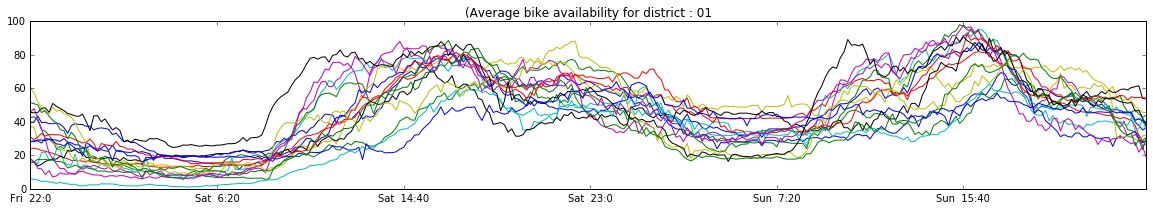

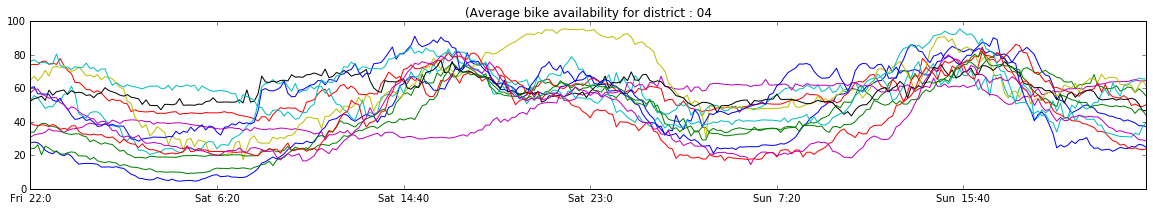

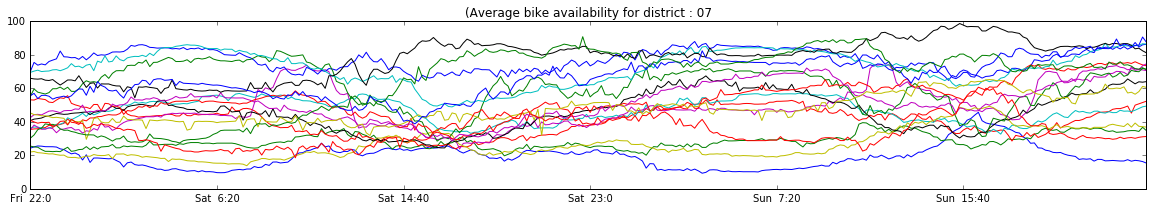

In [538]:
average_per_district(aow,stations,'01')
average_per_district(aow,stations,'04')
average_per_district(aow,stations,'07')

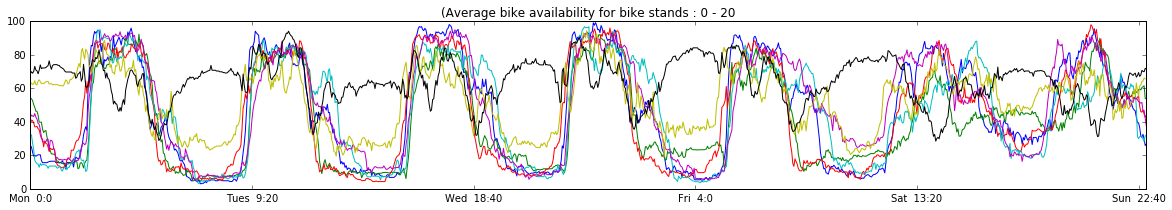

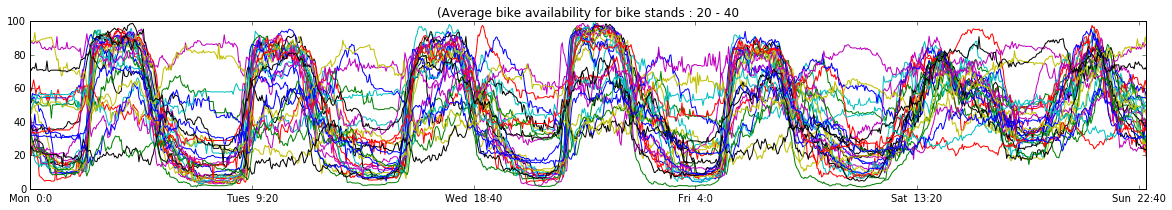

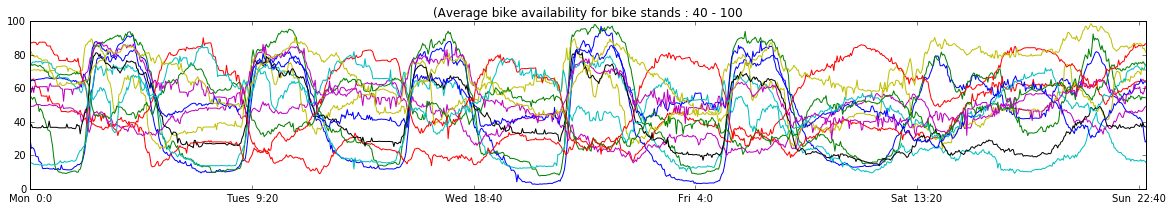

In [526]:
average_per_bike_stands_type(aow,stations,0,20)
average_per_bike_stands_type(aow,stations,20,40)
average_per_bike_stands_type(aow,stations,40,100)

##### => Key Learning - 'seasonality' 

*week day*:
- ```morning_rush_hour```: entre 7h30 et 10h
- ```workday```: entre 10h et 16h30
- ```evening_rush_hour```: entre 16h30 et 20h30
- ```night```: entre 20h30 et 7h30

*weekend*
- ```is_weekend```: si c'est le weekend


#### Bike flow per station

In [547]:
aow = average_on_week(av_bikes_sampled)

In [583]:
bikes_flow_table = av_bikes_table.resample('30min').first().ffill().diff()

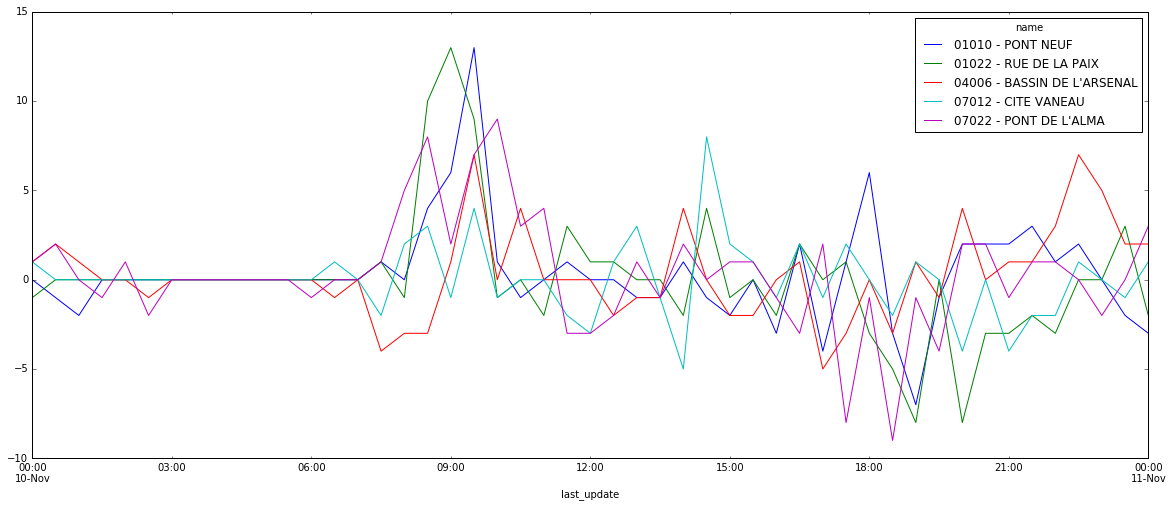

In [584]:
# ==> choosing station to plot
selected_colums = av_bikes_sampled.columns.values[::10]
start_date  = datetime.datetime(2015,11,10,0,0,0)
end_date  =  datetime.datetime(2015,11,11,0,0,0)
multi_station_plot(bikes_flow_table,selected_colums,start_date,end_date,legend=True)

In [585]:
bikes_flow_aow = average_on_week(bikes_flow_table)

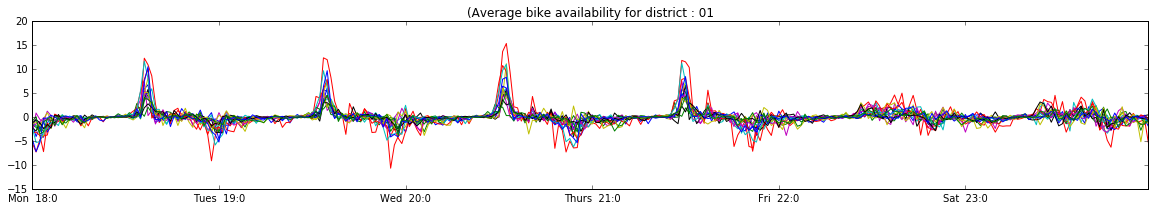

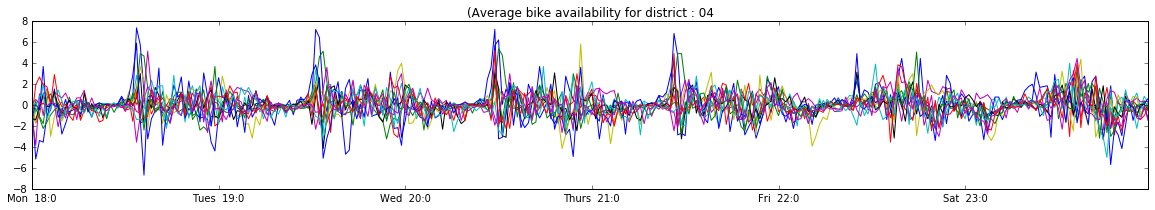

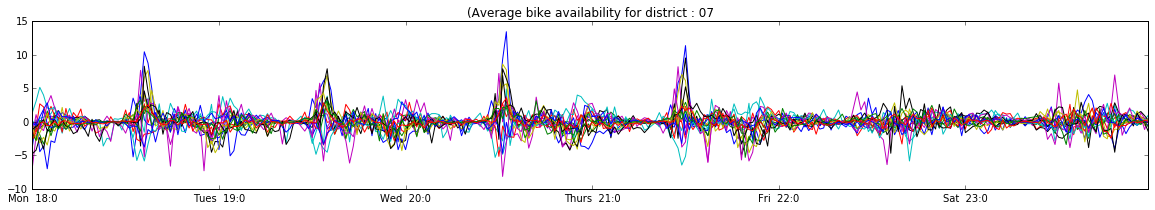

In [586]:
average_per_district(bikes_flow_aow,stations,'01')
average_per_district(bikes_flow_aow,stations,'04')
average_per_district(bikes_flow_aow,stations,'07')

## 3. Integrating External Data Sources

### 3.a

In [608]:
import json

weather_data=open('challenge_data/weather_data/paris_weather_20150831_20151130.jsonr').read()
data = json.loads(weather_data)
len(data)

4416

address  \
number last_update                                         
1010   2015-09-01 01:51:43  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:01:47  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:11:50  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:21:53  10 RUE BOUCHER - 75001 PARIS   
       2015-09-01 02:31:57  10 RUE BOUCHER - 75001 PARIS   

                            available_bike_stands  available_bikes banking  \
number last_update                                                           
1010   2015-09-01 01:51:43                     25                0    True   
       2015-09-01 02:01:47                     25                0    True   
       2015-09-01 02:11:50                     25                0    True   
       2015-09-01 02:21:53                     25                0    True   
       2015-09-01 02:31:57                     25                0    True   

                            bike_stands  bonus contract_name  index  \
number last_update                                                    
1010   2015-09-01 01:51:43           25  False         Paris  14015   
       2015-09-01 02:01:47           25  False         Paris   7503   
       2015-09-01 02:11:50           25  False         Paris  12609   
       2015-09-01 02:21:53           25  False         Paris    557   
       2015-09-01 02:31:57           25  False         Paris  10262   

                                  lat       lng               name status  
number last_update                                                         
1010   2015-09-01 01:51:43  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:01:47  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:11:50  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:21:53  48.859462  2.344366  01010 - PONT NEUF   OPEN  
       2015-09-01 02:31:57  48.859462  2.344366  01010 - PONT NEUF   OPEN